In [14]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd

import networkx as nx
import osmnx as ox
from libpysal import weights
import matplotlib.pyplot as plt
import momepy
from pydantic import UUID1
from shapely.geometry import Polygon, Point
from copy import deepcopy

In [15]:
DATA_PATH = Path(os.getcwd()).parent / "gjson_dataset"
DATA_PATH.exists()

True

In [16]:
PROJECTED_CRS = 32637
GEOGRAPHIC_CRS = 4326
PADDING = 0.001  # Padding in degrees

In [17]:
def merge_transport_datasets(bus_df: gpd.GeoDataFrame, subway_df: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    subway_df["Type"] = "Subway"

    subway_df.rename(columns={"Text": "Name"}, inplace=True)

    subway_df = subway_df.drop(columns=["Number"])
    bus_df = bus_df.drop(columns=["TrStopId"])
    bus_df.rename(columns={"TrType": "Type"}, inplace=True)
    
    merged_df = pd.concat([bus_df, subway_df], ignore_index=True)
    merged_gdf = gpd.GeoDataFrame(merged_df, geometry="geometry")
    return merged_gdf

def get_street_json(version: int) -> str:
    file = DATA_PATH / f"Streets_{version}очередь.geojson"
    assert file.exists()
    return file

def get_house_json(version: int) -> str:
    file = DATA_PATH / f"House_{version}очередь_ЖК.geojson"
    assert file.exists()
    return file

def get_transport_points_gdf() -> gpd.GeoDataFrame:
    social_gdf = merge_transport_datasets(
        bus_df=gpd.read_file(DATA_PATH / 'Остановки_ОТ.geojson'),
        subway_df=gpd.read_file(DATA_PATH / 'Выходы_метро.geojson')
    )
    return social_gdf

In [18]:
streets = gpd.read_file(get_street_json(2))  # This data is already in CRS "4326"
transport_points = get_transport_points_gdf()
transport_points.fillna(value="subway", inplace=True)
print(transport_points.head(3))
residential_complex = gpd.read_file(get_house_json(2))
residential_complex.drop(['District', 'Street', 'Number'], axis=1, inplace=True)
print("\n", residential_complex.head(2))

                   Type                Name                   geometry
0  Автобусная остановка          д. Дудкино  POINT (37.45345 55.63557)
1  Автобусная остановка  Академика Семёнова  POINT (37.50908 55.54359)
2  Автобусная остановка     СНТ Гавриково-1  POINT (37.50263 55.54162)

          Type    Purpose  Elevation  Entrances  Apartments  \
0  Жилые дома  Жилой дом         20        2.0       144.0   
1  Жилые дома  Жилой дом         17        5.0       384.0   

                                            geometry  
0  POLYGON ((37.49281 55.54246, 37.49370 55.54242...  
1  POLYGON ((37.49503 55.54135, 37.49550 55.54066...  


In [19]:
transport_points

,Type,Name,geometry
0,Автобусная остановка,д. Дудкино,POINT (37.45345 55.63557)
1,Автобусная остановка,Академика Семёнова,POINT (37.50908 55.54359)
2,Автобусная остановка,СНТ Гавриково-1,POINT (37.50263 55.54162)
3,Автобусная остановка,СНТ Берёзка-Коммунарка-1,POINT (37.48954 55.55831)
4,Автобусная остановка,СНТ Берёзка-Коммунарка-1,POINT (37.48878 55.55945)
...,...,...,...
63,Subway,Потапово,POINT (37.49107 55.55184)
64,Subway,Потапово,POINT (37.49547 55.55201)
65,Subway,Потапово,POINT (37.49652 55.55206)
66,Subway,Потапово,POINT (37.49682 55.55360)


In [20]:
residential_complex

,Type,Purpose,Elevation,Entrances,Apartments,geometry
0,Жилые дома,Жилой дом,20,2.0,144.0,"POLYGON ((37.49281 55.54246, 37.49370 55.54242..."
1,Жилые дома,Жилой дом,17,5.0,384.0,"POLYGON ((37.49503 55.54135, 37.49550 55.54066..."
2,Жилые дома,Малоэтажный жилой дом,3,4.0,86.0,"POLYGON ((37.49657 55.54595, 37.49617 55.54561..."
3,Жилые дома,Жилой дом,17,3.0,160.0,"MULTIPOLYGON (((37.49262 55.54119, 37.49315 55..."
4,Жилые дома,Жилой дом,17,3.0,189.0,"MULTIPOLYGON (((37.49425 55.54207, 37.49423 55..."
...,...,...,...,...,...,...
121,Известный по назначению,Пост охраны,1,NaN,NaN,"POLYGON ((37.49686 55.54271, 37.49682 55.54270..."
122,Известный по назначению,Хозяйственный корпус,1,NaN,NaN,"POLYGON ((37.48866 55.54695, 37.48869 55.54690..."
123,Известный по назначению,Хозяйственный корпус,1,NaN,NaN,"POLYGON ((37.48814 55.54722, 37.48821 55.54724..."
124,Известный по назначению,Хозяйственный корпус,1,NaN,NaN,"POLYGON ((37.48678 55.54976, 37.48680 55.54974..."


In [21]:
from typing import Tuple

CropBox = Tuple[float, float, float, float]

def crop_gdf(gdf: gpd.GeoDataFrame, crop: CropBox) -> gpd.GeoDataFrame:
    x_min, y_min, x_max, y_max = crop
    crop_region = Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)])
    return gdf[gdf.geometry.within(crop_region)]


def select_residence_region(residence_gdf: gpd.GeoDataFrame, padding: float = PADDING) -> tuple:
    x_min, y_min, x_max, y_max = residence_gdf.total_bounds
    x_min -= padding
    y_min -= padding
    x_max += padding
    y_max += padding
    return x_min, y_min, x_max, y_max

def get_area_occupied(crop_box: np.ndarray) -> float:
    return (crop_box[3] - crop_box[1]) * (crop_box[2] - crop_box[0]) * 10000

print(f"Bounds: \n- Streets: {streets.total_bounds} (Area {get_area_occupied(streets.total_bounds)})\n- Transport points: {transport_points.total_bounds} (Area {get_area_occupied(transport_points.total_bounds)})\n- Residence: {residential_complex.total_bounds} (Area {get_area_occupied(residential_complex.total_bounds)})\n")

Bounds: 
- Streets: [37.36832248 55.49836001 37.55370313 55.63672847] (Area 256.5083528636269)
- Transport points: [37.45140658 55.5377753  37.51263656 55.63556539] (Area 59.876852962148284)
- Residence: [37.47513854 55.54011687 37.49841506 55.55072636] (Area 2.469519160782267)



In [22]:
crop = select_residence_region(residential_complex)
# crop = (37.472381, 55.539195, 37.490082, 55.549288)
print(f"Crop: {crop}")


Crop: (37.47413854287298, 55.5391168724373, 37.499415059694385, 55.551726360015394)


In [23]:
# x_min, y_max = 37.472381, 55.549288
# x_max, y_min = 37.490082, 55.539195

In [24]:
streets = crop_gdf(streets, crop)
transport_points = crop_gdf(transport_points, crop)

In [25]:
def plot_gpd(lines: gpd.GeoDataFrame = None, points: gpd.GeoDataFrame = None, polygons: gpd.GeoDataFrame = None, ax=None, show=False):
    if ax is None:
        show = True
        _, ax = plt.subplots(figsize=(8, 8))
        ax.set_title('Streets and Transport Stops')
        ax.legend(labels=['lines', 'points'])
    if lines is not None:
        lines.plot(ax=ax, color='gray', label='lines')
    if points is not None:
        points.plot(
            ax=ax,
            color='red',  # Choose a color that contrasts well with the streets
            marker='o',   # Use circle markers for points
            # markersize=50,
            label='points'
        )
    if polygons is not None:
        polygons.plot(
            ax=ax,
            color='orange',  # Choose a color that contrasts well with the streets
            marker='o',   # Use circle markers for points
            markersize=50,
            # label='polygons'
        )

    if show:
        plt.show()
    
def plot_graph(graph: nx.MultiGraph):
    fig, ax = plt.subplots(figsize=(8, 8))

    nx.draw(
        graph, {n: [n[0], n[1]] for n in list(graph.nodes)}, ax=ax, node_size=5
    )

    ax.set_title('Graph')

    plt.show()

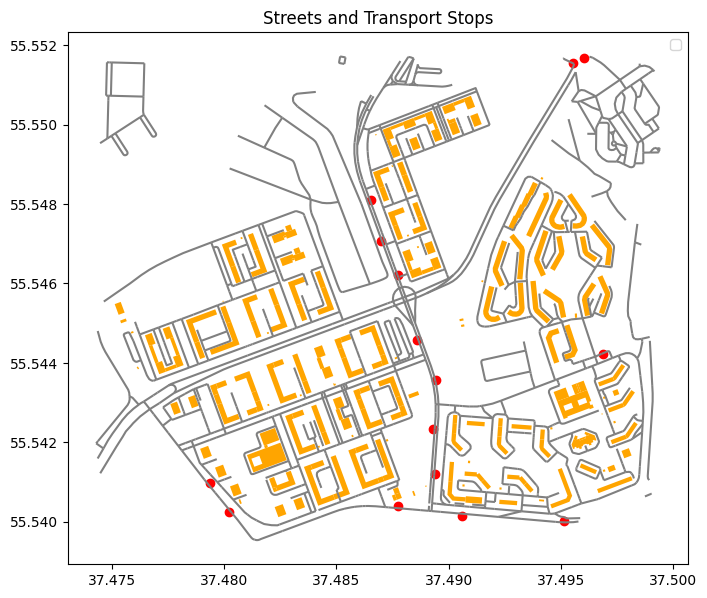

In [26]:
plot_gpd(streets, transport_points, residential_complex)

## Make projections on DataFrames 

In [27]:
projected_streets = streets.to_crs(epsg=PROJECTED_CRS)
projected_residence = residential_complex.to_crs(epsg=PROJECTED_CRS)
projected_transport_points = transport_points.to_crs(epsg=PROJECTED_CRS)

In [28]:
def get_graph(gdf: gpd.GeoDataFrame) -> nx.MultiGraph:
    gdf = gdf.iloc[:]
    if not gdf.crs.is_projected:
        print(f"DataFrame CRS is: {gdf.crs.srs} - not projected. Converting to {PROJECTED_CRS}...")
        gdf.to_crs(epsg=PROJECTED_CRS, inplace=True)
    return momepy.gdf_to_nx(gdf, approach="primal")

G = get_graph(streets)
G

DataFrame CRS is: EPSG:4326 - not projected. Converting to 32637...


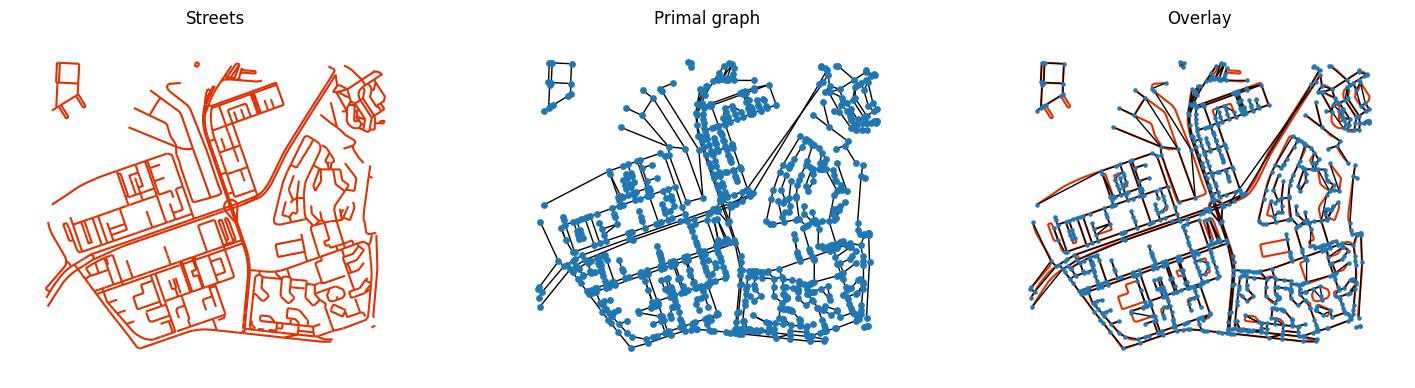

In [29]:
f, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
projected_streets.plot(color="#e32e00", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Primal graph", "Overlay")[i])
    facet.axis("off")
nx.draw(
    G, {n: [n[0], n[1]] for n in list(G.nodes)}, ax=ax[1], node_size=15
)
projected_streets.iloc[:1].plot(color="#e32e00", ax=ax[1], zorder=-1)  # Костыль, чтобы выровнять второй плот

projected_streets.plot(color="#e32e00", ax=ax[2], zorder=-1)
nx.draw(
    G, {n: [n[0], n[1]] for n in list(G.nodes)}, ax=ax[2], node_size=5
)

# Graph Analysis

## Connect houses and transport points to the Graph

In [30]:
def find_closest_node(point, graph):
    def euclidean_distance(node):
        x, y = node
        return np.sqrt(
                (x - point[0]) ** 2 + (y - point[1]) ** 2
        )
    return min(graph.nodes(), key=euclidean_distance)

In [31]:
from uuid import uuid4

In [32]:
def add_node(row: pd.Series, graph: nx.MultiGraph) -> None:
    centroid_point = (row["geometry"].centroid.x, row["geometry"].centroid.y)

    # Find the closest node in the street network
    closest_node = find_closest_node(centroid_point, G)

    # Add the building access point as a new node in the graph
    graph.add_node(centroid_point, NodeId=uuid4().int % 10 ** 8, **row.to_dict())
    print(f"added node: {centroid_point}")

    # Calculate the weight (distance) between the new node and the closest existing node
    weight = ((closest_node[0] - centroid_point[0]) ** 2 +
              (closest_node[1] - centroid_point[1]) ** 2) ** 0.5
    if weight:
        # Add an edge between the access point and the closest node in the street network
        graph.add_edge(centroid_point, closest_node, weight=weight, EdgeId=uuid4().int % 10 ** 8, )
        print(f"added edge with weight: {weight}")
    else:
        print(f"did not add edge due to zero weight")

## Before New nodes

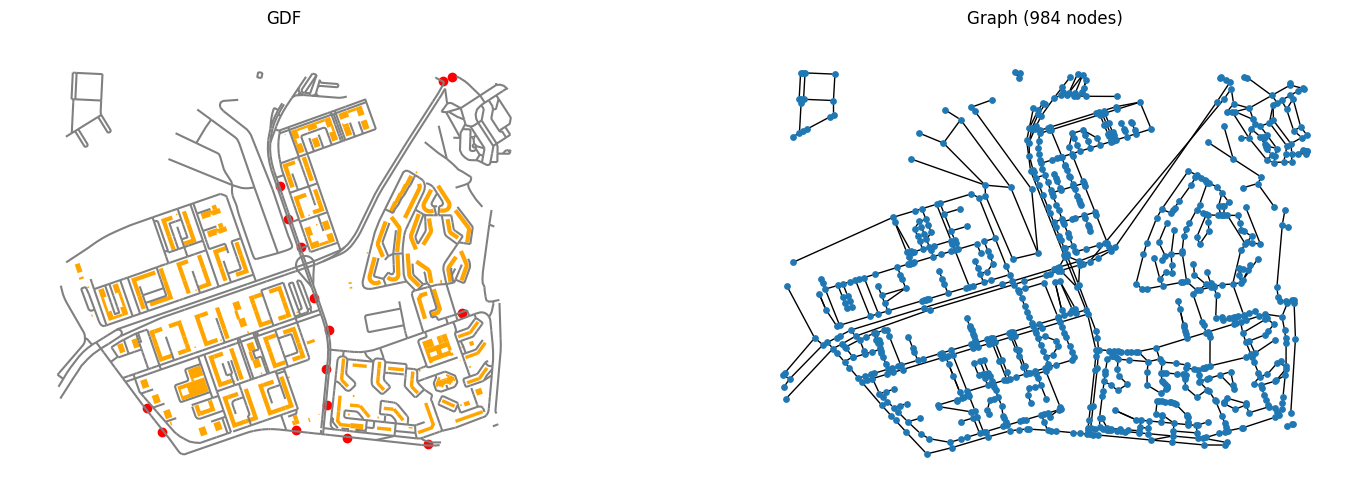

In [33]:
f, ax = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)

for i, facet in enumerate(ax):
    facet.set_title(("GDF", f"Graph ({len(G.nodes())} nodes)")[i])
    facet.axis("off")
nx.draw(
    G, {n: [n[0], n[1]] for n in list(G.nodes)}, ax=ax[1], node_size=15
)
plot_gpd(projected_streets, projected_transport_points, projected_residence, ax[0])

In [34]:
nodes_before = len(G.nodes)
print(f"Nodes before: {nodes_before}")
for idx, row in projected_residence.iterrows():
    add_node(row, G)
print(f"Residence Nodes added: {len(G.nodes) - nodes_before}")
for idx, row in projected_transport_points.iterrows():
    add_node(row, G)
print(f"Totally Nodes added: {len(G.nodes) - nodes_before}")

Nodes before: 984
added node: (404923.64209122706, 6156181.467032568)
added edge with weight: 18.773056155622882
added node: (405037.11564282584, 6155999.304610534)
added edge with weight: 13.299450065739222
added node: (405116.79988344066, 6156535.663966253)
added edge with weight: 4.794009805840697
added node: (404918.61625807284, 6156028.656295546)
added edge with weight: 30.88186160560638
added node: (404983.96432510926, 6156132.13546988)
added edge with weight: 16.33639593306155
added node: (405015.8365454626, 6156410.403777936)
added edge with weight: 49.14446654597787
added node: (405067.32616454887, 6156412.513966863)
added edge with weight: 34.10217562978551
added node: (404924.4626491559, 6156530.336331762)
added edge with weight: 12.888465939330636
added node: (404871.0407483529, 6156640.323955275)
added edge with weight: 12.10497624031585
added node: (404987.94699593, 6156666.5520972265)
added edge with weight: 19.6218912242481
added node: (405038.446794359, 6156665.3765887

## With New nodes

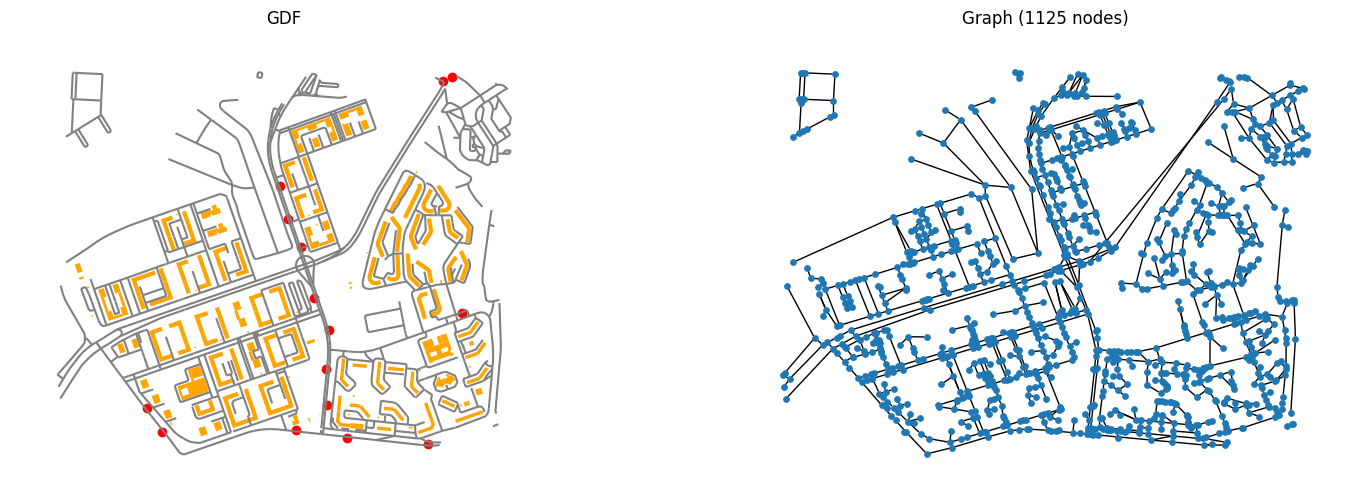

In [35]:
f, ax = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)

for i, facet in enumerate(ax):
    facet.set_title(("GDF", f"Graph ({len(G.nodes())} nodes)")[i])
    facet.axis("off")
nx.draw(
    G, {n: [n[0], n[1]] for n in list(G.nodes)}, ax=ax[1], node_size=15
)
plot_gpd(projected_streets, projected_transport_points, projected_residence, ax[0])

## Adding weights to graph

In [36]:
def ensure_weights(graph: nx.MultiGraph) -> None:
    for u, v, data in graph.edges(data=True):
        if 'weight' in data:
            continue
        elif 'mm_len' in data:
            # print(f"Found mm_len...")
            data['weight'] = data['mm_len']
            # print(f"Set edge weight to {data['weight']}")
        else:
            # Fallback: calculate weight based on geometry length
            print(f"Calculating weight...")
            line = data.get('geometry')
            if line:  # Check if geometry is present
                data['weight'] = line.length
            else:
                data['weight'] = 1  # Default weight if no length data available
            print(f"Set edge weight to {data['weight']}")

In [37]:
for node in G.nodes(data=True):
    print(node[-1])

{'x': 404001.38706603, 'y': 6156147.947085591}
{'x': 403984.673362738, 'y': 6156142.151042469}
{'x': 403968.08542415634, 'y': 6156136.403224369}
{'x': 403958.18223690544, 'y': 6156149.764840246}
{'x': 404047.12213861546, 'y': 6156163.796683712}
{'x': 403880.86431942886, 'y': 6156254.074805176}
{'x': 403863.8447712411, 'y': 6156275.434795581}
{'x': 404574.0658764624, 'y': 6156346.362941418}
{'x': 404518.0856885203, 'y': 6156327.003105773}
{'x': 404568.83805698325, 'y': 6156361.48222606}
{'x': 404566.89642462804, 'y': 6156367.103442909}
{'x': 404430.7148093853, 'y': 6156296.785316952}
{'x': 404424.207307146, 'y': 6156294.545072128}
{'x': 404467.3993710232, 'y': 6156466.788077664}
{'x': 404447.29463110317, 'y': 6156459.853877909}
{'x': 404658.36089556664, 'y': 6156375.518411114}
{'x': 404653.15562031075, 'y': 6156390.642649359}
{'x': 404624.45188163617, 'y': 6156380.714698159}
{'x': 404425.54162527935, 'y': 6156311.790609796}
{'x': 404431.9808419147, 'y': 6156314.021018704}
{'x': 404366.8

In [38]:
ensure_weights(G)

In [39]:
for edge in G.edges(data=True):
    print(edge[-1])

{'ST_NAME': '', 'ST_TYP_BEF': '', 'ST_NM_BASE': '', 'ROAD_CATEG': 'Прочие улицы города', 'RoadDirect': 'T', 'RbndStght': 1.0, 'RbndBck': 1.0, 'Width': 6.0, 'MaxSpdDrct': 0, 'AvgSpdDrct': 0, 'MaxSpdRvrs': 60, 'AvgSpdRvrs': 51, 'Foot': 1, 'Car': 1, 'geometry': <LINESTRING (404001.387 6156147.947, 403984.673 6156142.151)>, 'mm_len': 17.690166579423497, 'weight': 17.690166579423497}
{'ST_NAME': '', 'ST_TYP_BEF': '', 'ST_NM_BASE': '', 'ROAD_CATEG': 'Прочие улицы города', 'RoadDirect': 'F', 'RbndStght': 1.0, 'RbndBck': 1.0, 'Width': 6.0, 'MaxSpdDrct': 40, 'AvgSpdDrct': 40, 'MaxSpdRvrs': 0, 'AvgSpdRvrs': 0, 'Foot': 1, 'Car': 1, 'geometry': <LINESTRING (404001.387 6156147.947, 404047.122 6156163.797)>, 'mm_len': 48.40358070423663, 'weight': 48.40358070423663}
{'ST_NAME': '', 'ST_TYP_BEF': '', 'ST_NM_BASE': '', 'ROAD_CATEG': 'Прочие улицы города', 'RoadDirect': 'Any', 'RbndStght': 1.0, 'RbndBck': 1.0, 'Width': 6.0, 'MaxSpdDrct': 60, 'AvgSpdDrct': 60, 'MaxSpdRvrs': 60, 'AvgSpdRvrs': 60, 'Foot': 

In [40]:
import pickle

pickle.dump(G, open('graph_dump.pickle', 'wb'))
G = pickle.load(open('graph_dump.pickle', 'rb'))